<a href="https://colab.research.google.com/github/msc-acse/acse-9-independent-research-project-OliverJBoom/blob/master/Chai_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Linking to Github

In [1]:
from getpass import getpass
import os

user = "OliverJBoom"
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!rm -rf Chai_Base
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git Chai_Base

github password··········
Cloning into 'Chai_Base'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 17 (delta 3), reused 12 (delta 2), pack-reused 0
Unpacking objects: 100% (17/17), done.


## Linking to Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive/")
path = "/content/gdrive/My Drive/Chai/Data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


## Loading Packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

## Loading Data

In [0]:
cu_lme =  pd.read_csv("/content/gdrive/My Drive/Chai/Data/CuLME.csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
cu_shfe =  pd.read_csv("/content/gdrive/My Drive/Chai/Data/CuSHFE.csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
cu_com_s =  pd.read_csv("/content/gdrive/My Drive/Chai/Data/CuCOMS.csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
cu_com_p =  pd.read_csv("/content/gdrive/My Drive/Chai/Data/CuCOMP.csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)

universe = [cu_lme, cu_shfe, cu_com_s, cu_com_p] 

# Useful when you want to know which dataframe is being acted on
universe_dict = {"lme":cu_lme, "shfe":cu_shfe, "com s":cu_com_s, "com p":cu_com_p}

In [0]:
def price_rename(universe_dict):
  """Renaming the column of the dataframe values to price"""
  for df_name in universe_dict:
    df = universe_dict[df_name]
    df = df.rename(columns={'value':"price"})
    universe_dict[df_name] = df
  return universe_dict

universe_dict = price_rename(universe_dict)

## Initial EDA

In [0]:
df = universe_dict["lme"]  

In [0]:
def visualise_plots(universe_dict, frequency="MS"):
  """Plotting the line graph for all of the 
  instruments being inspected"""
  for df_name in universe_dict:
    df = universe_dict[df_name]
    plt.plot(df.index, df.price)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(df_name)
    plt.grid()
    plt.show()
    
# visualise_plots(universe_dict)

In [0]:
# df.head()
# visualise_plots(universe_dict)
# df.info()
# plt.hist((df.price), bins=20)
# plt.show()

In [9]:
def clean_outliers(df, n_std = 3):
  """Removes any outliers that are further than 3
  standard deviations from the mean"""
  upper = df.price.mean() + n_std * (df.price.std())
  lower = df.price.mean() - n_std * (df.price.std())
  
  orig_len = len(df)
  
  clean_df = df.price[(df.price < upper) & (df.price > lower)]
  
  if orig_len != len(clean_df):
    print("Number of rows removed:", orig_len - len(clean_df))
    
  return clean_df



def clean_dict_gen(universe_dict):
  """Returns a dictionary of cleaned dataframes"""
  cleaned_dict = {}
  
  for df in universe_dict:
    #print(df)
    cleaned_dict[df] = clean_outliers(universe_dict[df], n_std=3)
  
  return cleaned_dict

cleaned_dict = clean_dict_gen(universe_dict)



def quantile_generator(df, n_buckets):
  """Adds a column that contains the quantile 
  ranking of a dataframe"""
  
  df['quantile_rank']=pd.qcut(df.price, n_buckets, labels=False)
  
  return df

Number of rows removed: 28


In [0]:
# Exponentially weighted moving averages
# df['ema10'] = pd.Series.ewm(df.price, span=10).mean()
# Deciles

# Percentage Change

In [0]:
df["deciles"] = pd.qcut(df.price, 10, labels=False)
df["pct_delta"] = df.price.pct_change()
df = df.fillna(0)
df.head()
df["deciles_pct_delta"] = pd.qcut(df.pct_delta, 10, labels=False)
df["lg_return"] = np.log(df.price) - np.log(df.price.shift(1))
pd.ewma(df.price, span=1)


In [38]:
df.head()

,price,deciles,pct_change,lg_return,pct_delta,deciles_pct_delta
date,,,,,,
2006-08-29,7410.0,6,0.000000,NaN,0.000000,4
2006-08-30,7465.0,7,0.007422,0.007395,0.007422,7
2006-08-31,7719.0,7,0.034025,0.033459,0.034025,9
2006-09-01,7607.0,7,-0.014510,-0.014616,-0.014510,1
2006-09-04,7669.0,7,0.008150,0.008117,0.008150,7


In [0]:
d = {'price': [2, 4, 6, 10, 14, 20, 28]}
# d = {'price': [1, 2, 3, 4, 5, 6, 7]}
df = pd.DataFrame(data=d)
df.head(10)
df["MA"] = df.price.rolling(window=2).mean()

,price,MA,ema1,ema2,ema3,ema4
0,2,NaN,2.0,2.000000,2.000000,2.000000
1,4,3.0,4.0,3.500000,3.333333,3.250000
2,6,5.0,6.0,5.230769,4.857143,4.653061
3,10,8.0,10.0,8.450000,7.600000,7.110294
4,14,12.0,14.0,12.165289,10.903226,10.098543


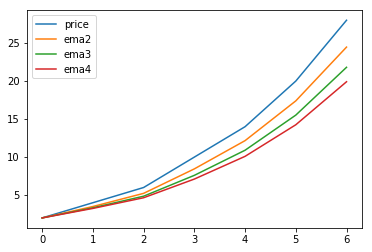

In [92]:
half_life_arr = [2, 3, 4]

for half_life in half_life_arr:
  df["ema" + str(half_life)] = df.price.ewm(span=half_life).mean()

plt.plot(df.index, df.price)
plt.plot(df.index, df.ema2)
plt.plot(df.index, df.ema3)
plt.plot(df.index, df.ema4)
plt.legend()
df.head()

In [0]:
# As the std is from a sample the degrees of freedom should be 1 
df["rolling_vol"] = df.price.rolling(window=2).std(ddof=1)

In [96]:
df.head()

,price,MA,ema1,ema2,ema3,ema4,rolling_vol
0,2,NaN,2.0,2.000000,2.000000,2.000000,NaN
1,4,3.0,4.0,3.500000,3.333333,3.250000,1.414214
2,6,5.0,6.0,5.230769,4.857143,4.653061,1.414214
3,10,8.0,10.0,8.450000,7.600000,7.110294,2.828427
4,14,12.0,14.0,12.165289,10.903226,10.098543,2.828427
